In [31]:
# PyTorch and Pyro imports
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, PyroOptim
from pyro.infer.mcmc.mcmc_kernel import MCMCKernel
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.distributions.transforms import Spline, ComposeTransform
from pyro.distributions import TransformedDistribution

# Utility imports
import GPUtil
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# Custom module imports
from xenium_cluster import XeniumCluster
from data import prepare_DLPFC_data, prepare_synthetic_data, prepare_Xenium_data

In [32]:
if torch.cuda.is_available():
    print("YAY! GPU available :3")
    
    # Get all available GPUs sorted by memory usage (lowest first)
    available_gpus = GPUtil.getAvailable(order='memory', limit=1)
    
    if available_gpus:
        selected_gpu = available_gpus[0]
        
        # Set the GPU with the lowest memory usage
        torch.cuda.set_device(selected_gpu)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        
        print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
    else:
        print("No GPUs available with low memory usage.")
else:
    print("No GPU available :(")

YAY! GPU available :3
Using GPU: 0 with the lowest memory usage.


# Potts Prior

The Potts prior is a prior distribution of cluster assignments given neighboring states. The general form of the Potts model is $$\pi(z_i) \propto \exp \left( \sum_i H(z_i) + \sum_{(i,j) \in G} J(z_i, z_j)\right)$$. H is the local potention representing some external influence of bias on the spot i. J is the interaction energy between neighboring sites. This represents the neighboring signals of spots, which is how we enforce the spatial clustering. The BayesSpace formulation feels like a more natural representation of this concept. $$\pi(z_i) \propto \exp \left( \frac{\gamma}{\langle ij \rangle} * 2\sum_{\langle ij \rangle} I(z_i = z_j)\right)$$ $\gamma$ is a smoothing parameter which can be tuned to increase the spatial contiguity of spatial assignments. 

In [33]:
class PottsPriorGibbs(MCMCKernel):
    
    def __init__(self, num_sites, num_clusters, neighbors, gamma):
        
        self.num_sites = num_sites
        self.num_clusters = num_clusters
        self.neighbors = neighbors
        self.gamma = gamma
        self.state = None

    def setup(self, initial_state):
        r"""
        Optional method to set up any state required at the start of the
        simulation run.

        :param int warmup_steps: Number of warmup iterations.
        :param \*args: Algorithm specific positional arguments.
        :param \*\*kwargs: Algorithm specific keyword arguments.
        """
        self.state = initial_state

    def cleanup(self):
        """
        Optional method to clean up any residual state on termination.
        """
        pass

    def logging(self):
        """
        Relevant logging information to be printed at regular intervals
        of the MCMC run. Returns `None` by default.

        :return: String containing the diagnostic summary. e.g. acceptance rate
        :rtype: string
        """
        return None

    def diagnostics(self):
        """
        Returns a dict of useful diagnostics after finishing sampling process.
        """
        # NB: should be not None for multiprocessing works
        return {}

    def end_warmup(self):
        """
        Optional method to tell kernel that warm-up phase has been finished.
        """
        pass

    @property
    def initial_params(self):
        """
        Returns a dict of initial params (by default, from the prior) to initiate the MCMC run.

        :return: dict of parameter values keyed by their name.
        """
        raise NotImplementedError

    @initial_params.setter
    def initial_params(self, params):
        """
        Sets the parameters to initiate the MCMC run. Note that the parameters must
        have unconstrained support.
        """
        raise NotImplementedError

    def sample(self, current_state):
        """
        Samples parameters from the posterior distribution, when given existing parameters.

        :param dict params: Current parameter values.
        :param int time_step: Current time step.
        :return: New parameters from the posterior distribution.
        """
        """Perform one Gibbs update over all sites."""
        new_state = current_state.clone()
        
        for i in range(self.num_sites):
            # Compute conditional probabilities for site i
            probs = torch.zeros(self.num_clusters)
            for k in range(self.num_clusters):
                # Compute the contribution of neighbors
                probs[k] = torch.sum(
                    torch.tensor([self.gamma if new_state[j] == k else 0.0 
                                  for j in self.neighbors[i]])
                )
            
            # Normalize to get valid probabilities
            probs = torch.exp(probs - torch.max(probs))  # Avoid numerical issues
            probs /= probs.sum()
            
            # Sample a new cluster label for site i
            new_state[i] = torch.multinomial(probs, 1).item()
        
        self.state = new_state
        return self.state

    def __call__(self, params):
        """
        Alias for MCMCKernel.sample() method.
        """
        return self.sample(params)


# Data Construction

We use the simulated dataset from the BayXenSmooth paper as an initial assessment of our idea. To make this happen we need to load in the data.

In [34]:
# Data Properties
batch_size = 2500
data_dimension = 25
num_clusters = 7
learn_global_variances = False

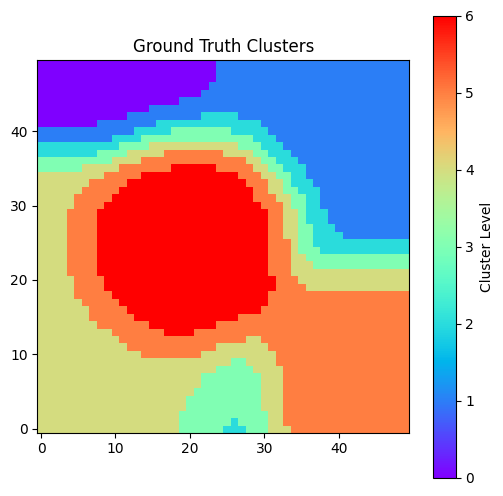

[-1.47257562  0.46511499  1.59663955  2.97219807 -4.86455653  2.14295514
 -2.04686034  4.86402576  3.46241731  0.60401181  0.97765685 -3.07924327
 -2.73748411 -3.45986822 -1.22186453 -3.88044556  0.11272894  1.38477955
 -3.77787622 -1.55803641 -4.2965212   0.25761187  1.50289769  1.15472141
  3.13869563] [[0.58891559 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         1.5454546  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.7570713  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.  

In [35]:
gene_data, spatial_locations, original_adata, TRUE_PRIOR_WEIGHTS = prepare_synthetic_data(num_clusters=num_clusters, data_dimension=data_dimension)
prior_means = torch.zeros(num_clusters, gene_data.shape[1])
prior_scales = torch.ones(num_clusters, gene_data.shape[1])

In [36]:
data = torch.tensor(gene_data).float()
num_obs, data_dim = data.shape

# Variational Inference

Objective: Given a Potts model for the prior and a GMM for the likelihood, how can we get a good posterior? 

In BayXenSmooth, we attempted to do this via an SVI framework where the posterior was approximated by another distribution with a desired paramteric form. This can be useful, but we want to model more complicated posteriors. This is where normalizing flows come in. By learning the posterior outcomes with complicated flows, we can plug in the flow as a variational distribution and train the variational inference procedure in a similar backprop way.

### Prior and Likelihood Calculations

Right now, we're re-using the old janky empirical prior that BayXenSmooth used. Eventually, the Potts model will be integrated. For now, the objective is to see how spatially contiguous spatial clusters look.

In [37]:
# Global Params to Set
neighborhood_size = 1
neighborhood_agg = "mean"
num_pcs = 3

def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, num_clusters=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
    elif method == "mclust":
        original_adata.pca(original_adata.xenium_spot_data, num_pcs)
        initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G=K, model_name = "EEE")
    elif method == "random":
        initial_clusters = np.random.randint(0, K, size=original_adata.xenium_spot_data.X.shape[0])
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

In [38]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial import KDTree
import numpy as np

# Clamping
MIN_CONCENTRATION = 0.01

num_posterior_samples = 1000

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.zeros(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

initial_clusters = custom_cluster_initialization(original_adata, "K-Means", K=num_clusters)

for i in range(num_clusters):
    cluster_data = gene_data[initial_clusters == i]
    if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
        empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
        empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

locations_tensor = torch.tensor(spatial_locations.to_numpy())

# Compute the number of elements in each dimension
num_spots = cluster_probs_prior.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]
    # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "mean":
        neighborhood_priors = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/1)
            # print(weight)
            return weight / weight.sum()
        neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update the cluster probabilities
    spatial_cluster_probs_prior[i] += neighborhood_priors

spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
sample_for_assignment_options = [True, False]

num_prior_samples = 100
for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).detach().mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid_PRIOR = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid_PRIOR.cpu(), cmap=colors, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

/home/roko/diff/nf/xenium_cluster.py:347: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = torch.tensor(data.obs["row"].astype(int))
/home/roko/diff/nf/xenium_cluster.py:348: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cols = torch.tensor(data.obs["col"].astype(int))
/home/roko/diff/nf/xenium_cluster.py:349: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clusters = torch.tensor(data.obs["cluster"].astype(int))
/home/roko/diff/n

In [23]:
torch.set_printoptions(sci_mode=False)
NUM_PARTICLES = 25

expected_total_param_dim = 2 # K x D

def model(data):

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(prior_means, 10.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(prior_scales, 10.0).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(spatial_cluster_probs_prior[ind]))
        # print(cluster_probs.mean(dim=0)[0])
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )

### Variational Guide

In [24]:
def normalizing_flow(K, data_dim, flow_length = 32, simplex_transform = "stick"):
    
    if simplex_transform == "stick":
        flow_dim = K - 1
    else:
        flow_dim = K

    # Base distribution: standard normal for the entire batch and feature dimensions
    base_dist = dist.Normal(
        torch.zeros(flow_dim),  # Batch size and feature dimensions
        torch.ones(flow_dim)
    ).to_event(1)

    # Define transformations based on flow_length
    transforms = []
    for i in range(flow_length):
        if i % 2 == 0:
            transform = T.conditional_spline(flow_dim, context_dim=data_dim, hidden_dims = [128, 128, 128], bound=3.0)
        else:
            transform = T.conditional_matrix_exponential(flow_dim, context_dim=data_dim, hidden_dims = [128, 128, 128])
        transforms.append(transform)
        pyro.module(f"transform_{i}", transform)

    # Add stickbreaking transform if simplex_transform is "stick"
    if simplex_transform == "stick":
        stickbreaking_transform = T.StickBreakingTransform()
        transforms.append(stickbreaking_transform)
        # pyro.module("stickbreaking_transform", stickbreaking_transform)

    # Apply transforms for the batch
    flow_dist = dist.ConditionalTransformedDistribution(
        base_dist, 
        transforms
    )

    return flow_dist

In [25]:
cluster_probs_flow_dist = normalizing_flow(num_clusters, data_dim)

def guide(data):
    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for cluster means and scales
        cluster_means_q_mean = pyro.param("cluster_means_q_mean", prior_means + torch.randn_like(prior_means) * 0.05)
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", prior_scales + torch.randn_like(prior_scales) * 0.01, constraint=dist.constraints.positive)
        if learn_global_variances:
            cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(prior_means) * 1.0, constraint=dist.constraints.positive)
            cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(prior_scales) * 0.25, constraint=dist.constraints.positive)
            cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
        else:
            cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]

        cluster_probs = pyro.sample("cluster_probs", cluster_probs_flow_dist.condition(batch_data))

# Training the Model

In [26]:
pyro.clear_param_store()
NUM_EPOCHS = 1000
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q_mean':
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    elif param_name == 'cluster_scales_q_mean':
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    elif "logit" in param_name:
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    else:
        return {"lr": 0.005, "betas": (0.9, 0.999)}

scheduler = Adam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

epoch_pbar = tqdm(range(NUM_EPOCHS))
PATIENCE = 5
current_min_loss = float('inf')
patience_counter = 0
for epoch in range(1, NUM_EPOCHS + 1):
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
    epoch_pbar.set_description(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
    print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
    if running_loss > current_min_loss:
        patience_counter += 1
    else:
        current_min_loss = running_loss
        patience_counter = 0
    if patience_counter >= PATIENCE:
        break 

Epoch 19 : loss = -856.6876:   0%|          | 0/1000 [01:00<?, ?it/s]


Epoch 1 : loss = 60.1998


Epoch 2 : loss = 60.1623


Epoch 3 : loss = 60.1106


Epoch 4 : loss = 60.0635


Epoch 5 : loss = 59.9203


Epoch 6 : loss = 59.8591


Epoch 7 : loss = 59.7568


Epoch 8 : loss = 59.5145


Epoch 9 : loss = 59.5211


Epoch 10 : loss = 59.3775


Epoch 11 : loss = 59.018


Epoch 12 : loss = 59.0725


Epoch 13 : loss = 58.9087


Epoch 14 : loss = 58.5278


Epoch 15 : loss = 58.5458


Epoch 16 : loss = 58.3896


Epoch 17 : loss = 58.0437


Epoch 18 : loss = 58.0248


Epoch 19 : loss = 57.6459


Epoch 20 : loss = 57.6414


Epoch 21 : loss = 57.4498


Epoch 22 : loss = 57.253


Epoch 23 : loss = 57.087


Epoch 24 : loss = 56.8939


Epoch 25 : loss = 56.679


Epoch 26 : loss = 56.4926


Epoch 27 : loss = 56.3224


Epoch 28 : loss = 56.1077


Epoch 29 : loss = 55.9011


Epoch 30 : loss = 55.6962


Epoch 31 : loss = 55.5187


Epoch 32 : loss = 55.3293


Epoch 33 : loss = 55.1081


Epoch 34 : loss = 54.9337


Epoch 35 : loss = 54.7495


Epoch 36 : loss = 54.5208


Epoch 37 : loss = 54.3096


Epoch 38 : loss = 54.1037


Epoch 39 : loss = 53.7816


Epoch 40 : loss = 53.7142


Epoch 41 : loss = 53.5301


Epoch 42 : loss = 53.2853


Epoch 43 : loss = 53.1024


Epoch 44 : loss = 52.6915


Epoch 45 : loss = 52.5595


Epoch 46 : loss = 52.4085


Epoch 47 : loss = 52.2826


Epoch 48 : loss = 52.0118


Epoch 49 : loss = 51.8579


Epoch 50 : loss = 51.6473


Epoch 51 : loss = 51.4103


Epoch 52 : loss = 51.1978


Epoch 53 : loss = 50.9703


Epoch 54 : loss = 50.7533


Epoch 55 : loss = 50.5042


Epoch 56 : loss = 50.3256


Epoch 57 : loss = 50.1118


Epoch 58 : loss = 49.9166


Epoch 59 : loss = 49.6936


Epoch 60 : loss = 49.4914


Epoch 61 : loss = 49.3256


Epoch 62 : loss = 49.1065


Epoch 63 : loss = 48.9306


Epoch 64 : loss = 48.5961


Epoch 65 : loss = 48.525


Epoch 66 : loss = 48.3568


Epoch 67 : loss = 48.1831


Epoch 68 : loss = 47.9431


Epoch 69 : loss = 47.7814


Epoch 70 : loss = 47.6216


Epoch 71 : loss = 47.3569


Epoch 72 : loss = 47.2981


Epoch 73 : loss = 47.1275


Epoch 74 : loss = 46.9496


Epoch 75 : loss = 46.8347


Epoch 76 : loss = 46.6257


Epoch 77 : loss = 46.5229


Epoch 78 : loss = 46.3785


Epoch 79 : loss = 46.1375


Epoch 80 : loss = 46.0951


Epoch 81 : loss = 45.9397


Epoch 82 : loss = 45.8439


Epoch 83 : loss = 45.7084


Epoch 84 : loss = 45.5794


Epoch 85 : loss = 45.414


Epoch 86 : loss = 45.2607


Epoch 87 : loss = 45.2714


Epoch 88 : loss = 45.1234


Epoch 89 : loss = 45.0458


Epoch 90 : loss = 44.9255


Epoch 91 : loss = 44.7541


Epoch 92 : loss = 44.6618


Epoch 93 : loss = 44.6641


Epoch 94 : loss = 44.5955


Epoch 95 : loss = 44.4737


Epoch 96 : loss = 44.3942


Epoch 97 : loss = 44.3435


Epoch 98 : loss = 44.2727


Epoch 99 : loss = 44.1731


Epoch 100 : loss = 44.0943


Epoch 101 : loss = 44.0597


Epoch 102 : loss = 43.8514


Epoch 103 : loss = 43.9084


Epoch 104 : loss = 43.8506


Epoch 105 : loss = 43.8193


Epoch 106 : loss = 43.7199


Epoch 107 : loss = 43.6899


Epoch 108 : loss = 43.6401


Epoch 109 : loss = 43.5781


Epoch 110 : loss = 43.531


Epoch 111 : loss = 43.2988


Epoch 112 : loss = 43.4266


Epoch 113 : loss = 43.4122


Epoch 114 : loss = 43.369


Epoch 115 : loss = 43.329


Epoch 116 : loss = 43.2796


Epoch 117 : loss = 43.2636


Epoch 118 : loss = 43.1664


Epoch 119 : loss = 43.1155


Epoch 120 : loss = 43.1382


Epoch 121 : loss = 43.1


Epoch 122 : loss = 43.0954


Epoch 123 : loss = 43.0415


Epoch 124 : loss = 43.0356


Epoch 125 : loss = 42.8938


Epoch 126 : loss = 42.9998


Epoch 127 : loss = 42.9479


Epoch 128 : loss = 42.9429


Epoch 129 : loss = 42.8197


Epoch 130 : loss = 42.8333


Epoch 131 : loss = 42.8663


Epoch 132 : loss = 42.8446


Epoch 133 : loss = 42.8216


Epoch 134 : loss = 42.6734


Epoch 135 : loss = 42.8048


Epoch 136 : loss = 42.7825


Epoch 137 : loss = 42.7797


Epoch 138 : loss = 42.7587


Epoch 139 : loss = 42.7271


In [29]:
with pyro.plate("data", len(data)):
    cluster_probs = pyro.sample("cluster_probs", cluster_probs_flow_dist.condition(data))
cluster_assignments_posterior = cluster_probs.argmax(dim=-1)

/tmp/ipykernel_3136623/3685937907.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_grid[rows, columns] = cluster_assignments_posterior + 1
/tmp/ipykernel_3136623/3685937907.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters + 1)


Text(0.5, 1.0, 'Posterior Cluster Assignment with BayXenSmooth')

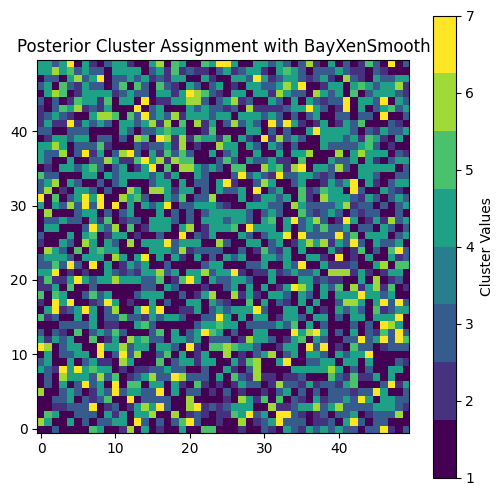

In [30]:
rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = cluster_assignments_posterior + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid.cpu(), cmap=colors, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
plt.title('Posterior Cluster Assignment with BayXenSmooth')